# Riiid Answer Correctness Prediction Dataset 

## Dataset Characteristics

**Has GROUPING field**

* currently keep_last_repeated_learning_activities function does not work because of memory issues -> therefore it is deactivated

## Preliminaries

### Constants

In [1]:
# paths
PATH_TO_INTERACTION_DATA = '../../../../../data/riiid-test-answer-prediction/train.csv'
PATH_TO_QUESTION_DATA = '../../../../../data/riiid-test-answer-prediction/questions.csv'
PATH_TO_LECTURE_DATA = '../../../../../data/riiid-test-answer-prediction/lectures.csv'

# dataset name
DATASET_NAME = 'riiid_answer_correctness_prediction'

# fields used in the analysis
USER_FIELD = 'user_id'
GROUP_FIELD = 'part'
LEARNING_ACTIVITY_FIELD = 'content_id'

# fields used in dataset preparation
TIMESTAMP_FIELD = 'timestamp'
CONTENT_TYPE_FIELD = 'content_type_id'

### Import Packages

In [2]:
from utilities.sequence_similarity import *
from utilities.sequence_similarity_no_group import *
from utilities.functions import *
from utilities.constants import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import textdistance as td
import pickle

### Seaborn Configuration

In [3]:
sns.set(rc = {'figure.figsize':(15,8)})

In [4]:
#sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":20, "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":20, "legend.title_fontsize":20})   

In [5]:
sns.set_style("darkgrid")

In [6]:
marker_config = {"marker":"o",
                 "markerfacecolor":"white", 
                 "markeredgecolor":"black",
                 "markersize":"10"}

### Import Pickled Objects

In [7]:
# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'rb') as f:
#     seq_dist_per_group_dict = pickle.load(f)

# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, 'rb') as f:
#     seq_dist_dict = pickle.load(f)

## Functions

## Dataset Preparation

### Import Data

In [8]:
interactions = pd.read_csv(PATH_TO_INTERACTION_DATA, usecols=[USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD, CONTENT_TYPE_FIELD])
questions = pd.read_csv(PATH_TO_QUESTION_DATA)
lectures = pd.read_csv(PATH_TO_LECTURE_DATA)

In [9]:
interactions

,timestamp,user_id,content_id,content_type_id
0,0,115,5692,0
1,56943,115,5716,0
2,118363,115,128,0
3,131167,115,7860,0
4,137965,115,7922,0
...,...,...,...,...
101230327,428564420,2147482888,3586,0
101230328,428585000,2147482888,6341,0
101230329,428613475,2147482888,4212,0
101230330,428649406,2147482888,6343,0


In [10]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [11]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


### Merge and Filter Data

In [12]:
# lectures do not have correct/incorrect values
# lecture have unspecified part fields
# only few interactions are lectures
# -> filter out lectures for better consistency

In [13]:
interactions = interactions.loc[interactions.content_type_id==0, :]

In [14]:
questions = questions.rename(columns={'question_id': 'content_id'})

In [15]:
interactions = interactions.merge(questions, on='content_id', how='inner')

### Filter Sequences by NAs in Dataset 

In [16]:
# only timestamps contain NAs
pct_na = get_nas_in_data(interactions)
pct_na

timestamp                             0.0 %
user_id                               0.0 %
content_id                            0.0 %
content_type_id                       0.0 %
bundle_id                             0.0 %
correct_answer                        0.0 %
part                                  0.0 %
tags               1.0073404901517358e-06 %
dtype: object

In [17]:
interactions = drop_na_by_fields(interactions, field_list=[GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD])

Input length: 99271300
Outpunt length: 99271300
Number of rows removed: 0
Percentage of rows removed: 0%


### Sort by Timestamp

In [18]:
interactions = sort_by_timestamp(interactions, TIMESTAMP_FIELD, higher_level_sort_list=[GROUP_FIELD, USER_FIELD])

### Transform Data

In [19]:
#interactions = keep_last_repeated_learning_activities(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD)

## Summary Statistics and Plots 

In [20]:
print_summary_stats(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, USER_FIELD_NAME_STR, GROUP_FIELD_NAME_STR, LEARNING_ACTIVITY_FIELD_NAME_STR, has_group_field=True)

number of interactions: 99271300
number of unique Topics: 7
number of unique Users: 393656
number of unique Learning Resources: 13523


### Dataset Specific Characteristics

### Interactions per User

In [21]:
interactions_per_user = print_and_return_interactions_per_user(interactions, USER_FIELD, USER_FIELD_NAME_STR)

mean number of interactions per User: 252.17778974536142
median number of interactions per User: 40.0
max number of interactions per User: 17609
min number of interactions per User: 1


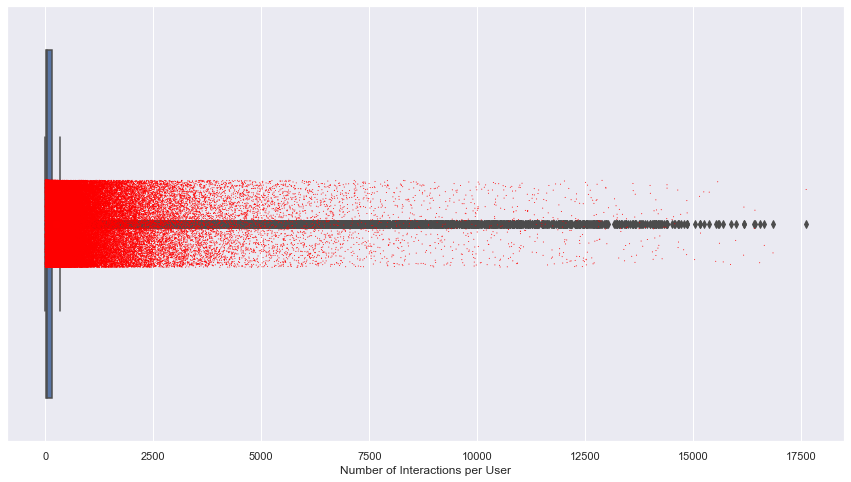

In [22]:
g = sns.boxplot(data=interactions_per_user, x='number of interactions', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=interactions_per_user, x='number of interactions', size=1, color="red");
g.set(xlabel='Number of Interactions per User');

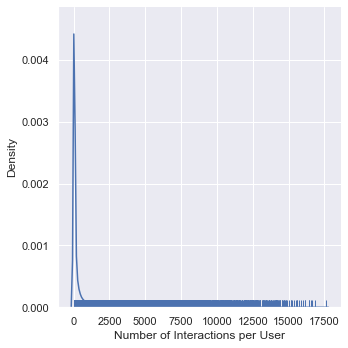

In [23]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='kde', rug=True)
g.set(xlabel='Number of Interactions per User');

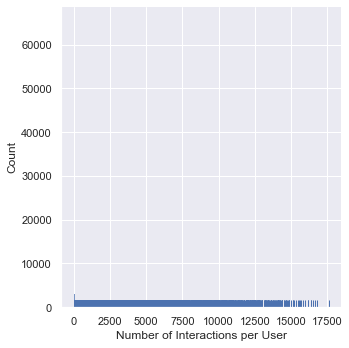

In [24]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel='Number of Interactions per User');

### Number of Unique Groups per User

In [25]:
n_unique_groups_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, GROUP_FIELD, NUMBER_UNIQUE_GROUPS_PER_USER_STR)

mean Number of Unique Topics per User: 4.635925782917065
median Number of Unique Topics per User: 5.0
max Number of Unique Topics per User: 7
min Number of Unique Topics per User: 1


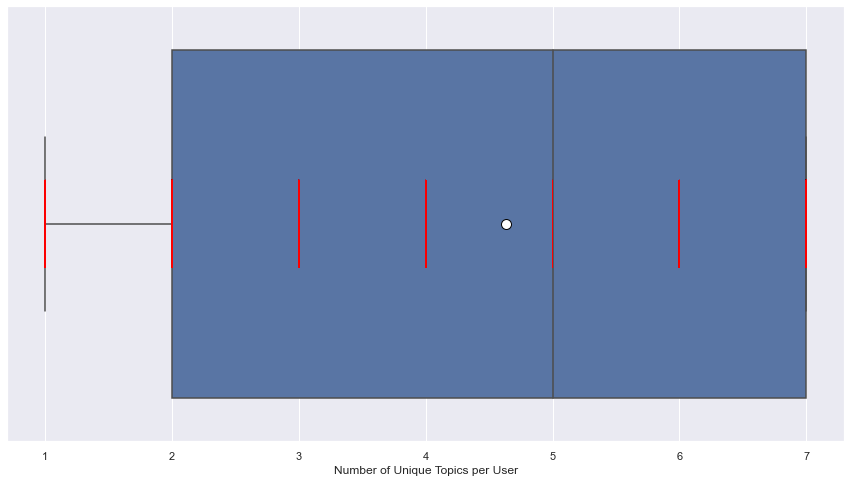

In [26]:
g = sns.boxplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

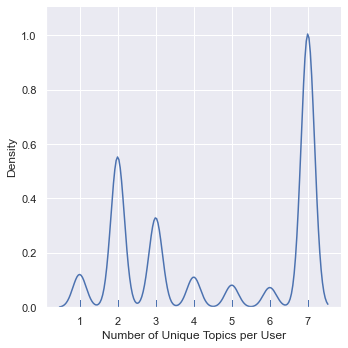

In [27]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

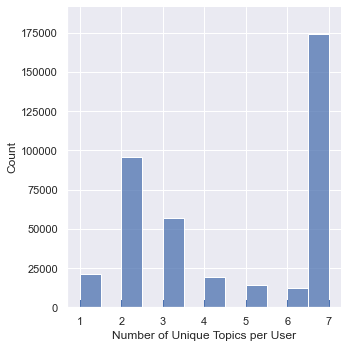

In [28]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=0.5)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

### Number of Unique Learning Activities per User

In [29]:
n_unique_learning_activities_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR)

mean Number of Unique Learning Resources per User: 220.66736185908508
median Number of Unique Learning Resources per User: 40.0
max Number of Unique Learning Resources per User: 11218
min Number of Unique Learning Resources per User: 1


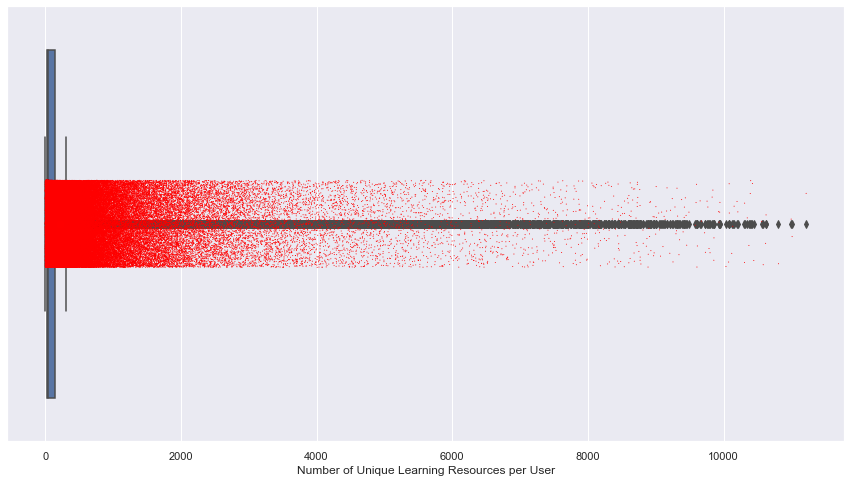

In [30]:
g = sns.boxplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

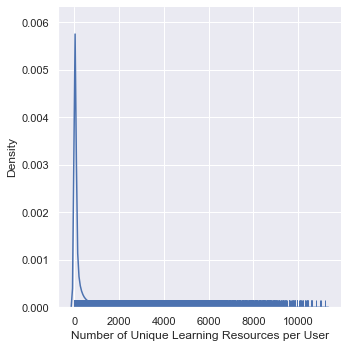

In [31]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

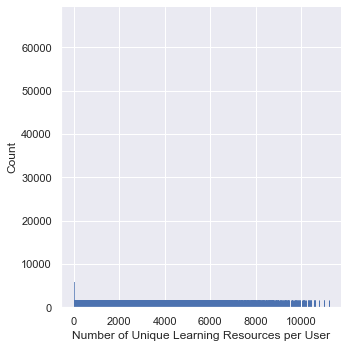

In [32]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

### Number of Unique Users per Group

In [33]:
n_unique_users_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_GROUP_STR)

mean Number of Unique Users per Topic: 260708.57142857142
median Number of Unique Users per Topic: 207734.0
max Number of Unique Users per Topic: 384536
min Number of Unique Users per Topic: 186657


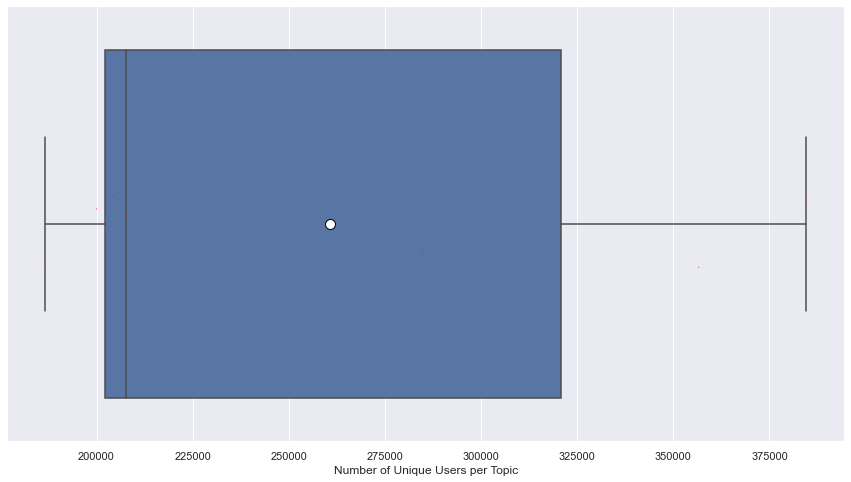

In [34]:
g = sns.boxplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

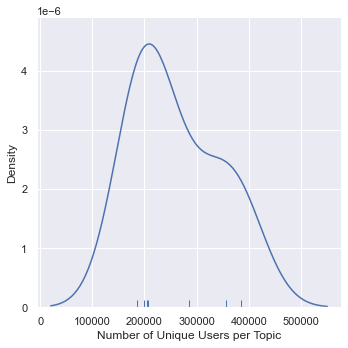

In [35]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

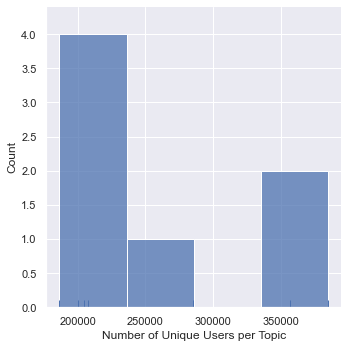

In [36]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

### Number of Unique Learning Activities per Group

In [37]:
n_unique_learning_activities_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR)

mean Number of Unique Learning Resources per Topic: 1931.857142857143
median Number of Unique Learning Resources per Topic: 1439.0
max Number of Unique Learning Resources per Topic: 5511
min Number of Unique Learning Resources per Topic: 992


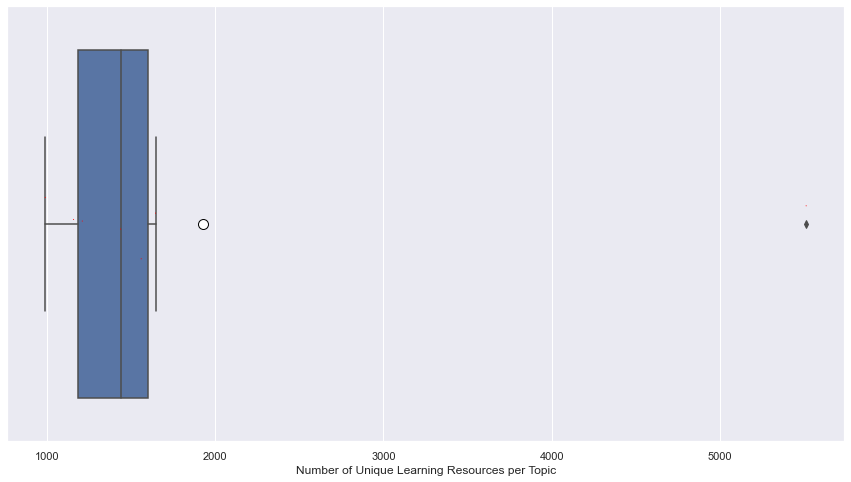

In [38]:
g = sns.boxplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

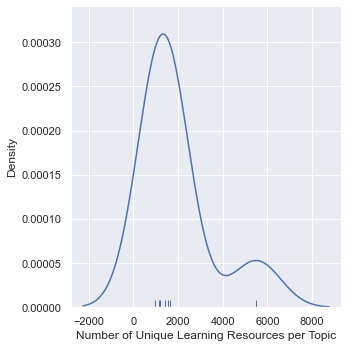

In [39]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

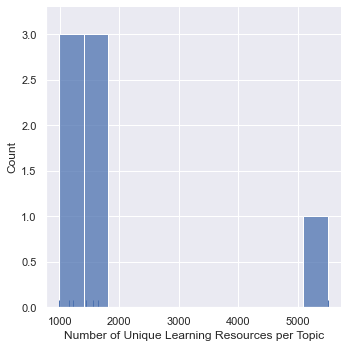

In [40]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

### Number of Unique Users per Learning Activity

In [41]:
n_unique_users_per_learning_activity = print_and_return_unique_col2_per_col1(interactions, LEARNING_ACTIVITY_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR)

mean Number of Unique Users per Learning Resource: 6423.650891074466
median Number of Unique Users per Learning Resource: 4301.0
max Number of Unique Users per Learning Resource: 189998
min Number of Unique Users per Learning Resource: 1


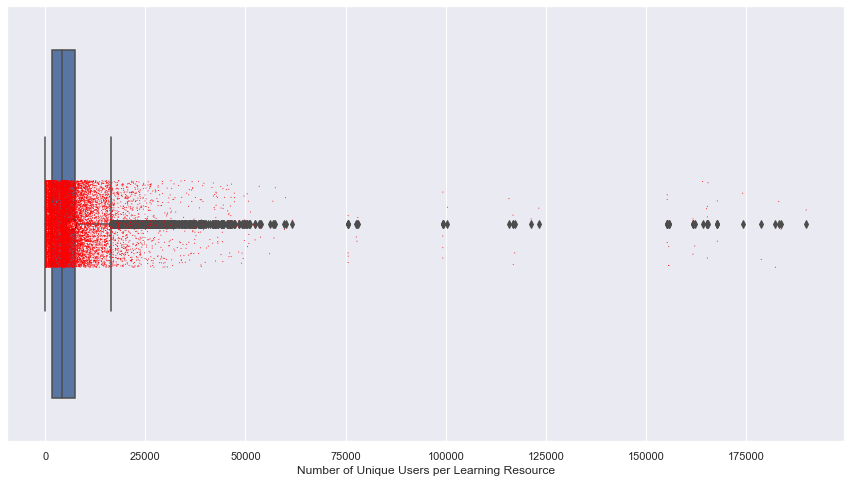

In [42]:
g = sns.boxplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

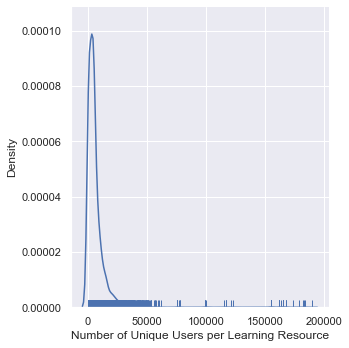

In [43]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

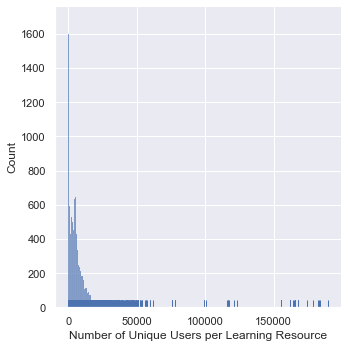

In [44]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

### Avg Number of Interactions over Groups for a User (User Sequence Length)

In [45]:
mean_n_interactions_over_groups, median_n_interactions_over_groups = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR)

mean of Mean Number of Interactions over Topics for a User: 48.19107614037337
median of Mean Number of Interactions over Topics for a User: 13.5
max of Mean Number of Interactions over Topics for a User: 4066.0
min of Mean Number of Interactions over Topics for a User: 1.0

__________________________________________________

mean of Median Number of Interactions over Topics for a User: 36.39760984209563
median of Median Number of Interactions over Topics for a User: 10.0
max of Median Number of Interactions over Topics for a User: 4066.0
min of Median Number of Interactions over Topics for a User: 1.0


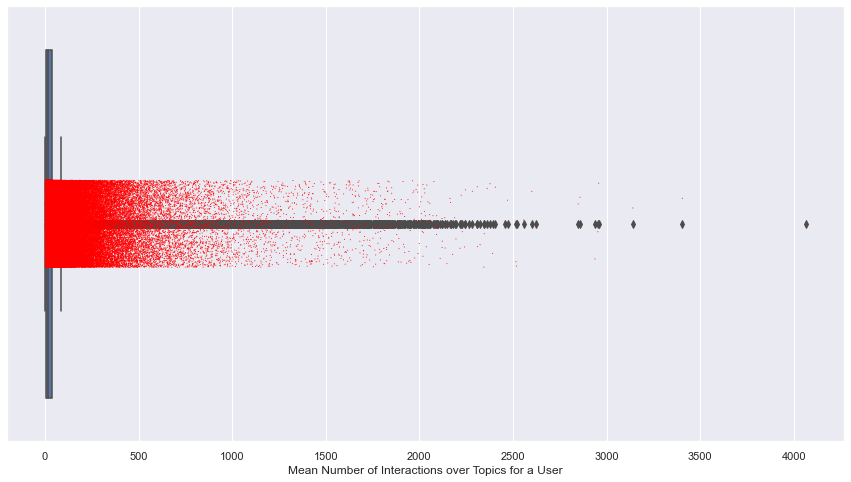

In [46]:
g = sns.boxplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

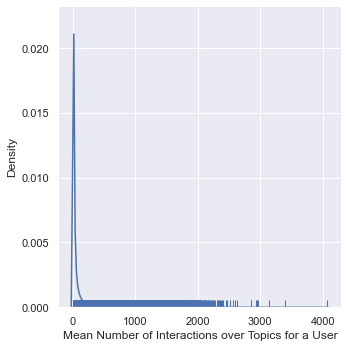

In [47]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

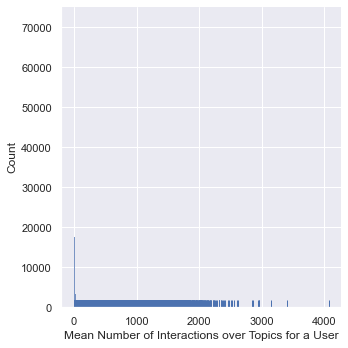

In [48]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

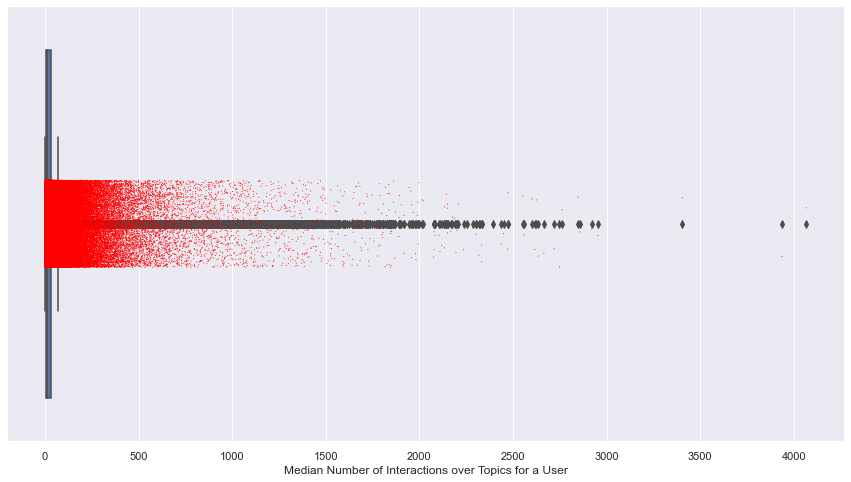

In [49]:
g = sns.boxplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

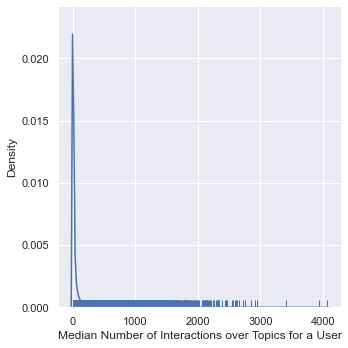

In [50]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

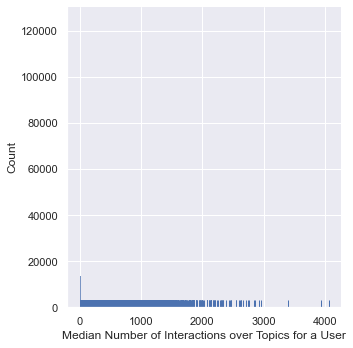

In [51]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

### Avg Number of Interactions over Users for a Group (Group Sequence Length)

In [52]:
mean_n_interactions_over_users, median_n_interactions_over_users = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR)

mean of Mean Number of Interactions over Users for a Topic: 49.276764713562365
median of Mean Number of Interactions over Users for a Topic: 41.59120317328892
max of Mean Number of Interactions over Users for a Topic: 106.38315528325046
min of Mean Number of Interactions over Users for a Topic: 26.165291344773486

__________________________________________________

mean of Median Number of Interactions over Users for a Topic: 7.571428571428571
median of Median Number of Interactions over Users for a Topic: 4.0
max of Median Number of Interactions over Users for a Topic: 19.0
min of Median Number of Interactions over Users for a Topic: 3.0


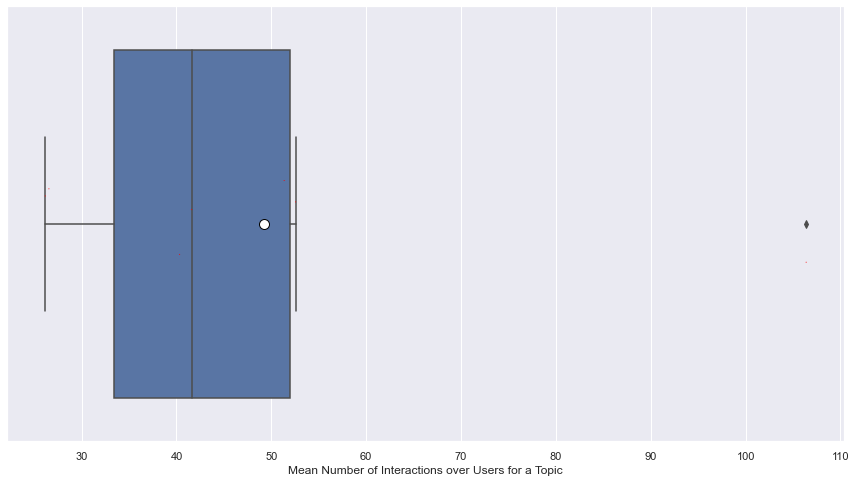

In [53]:
g = sns.boxplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

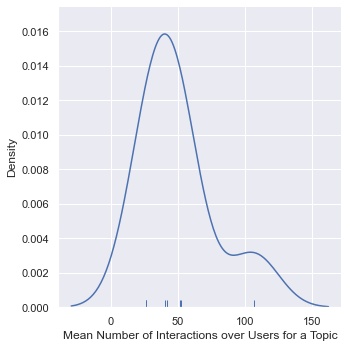

In [54]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

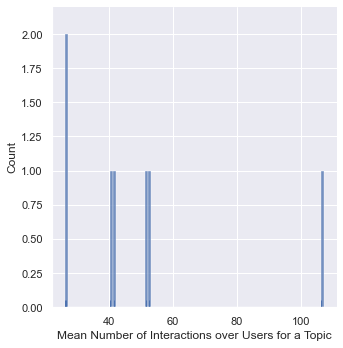

In [55]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

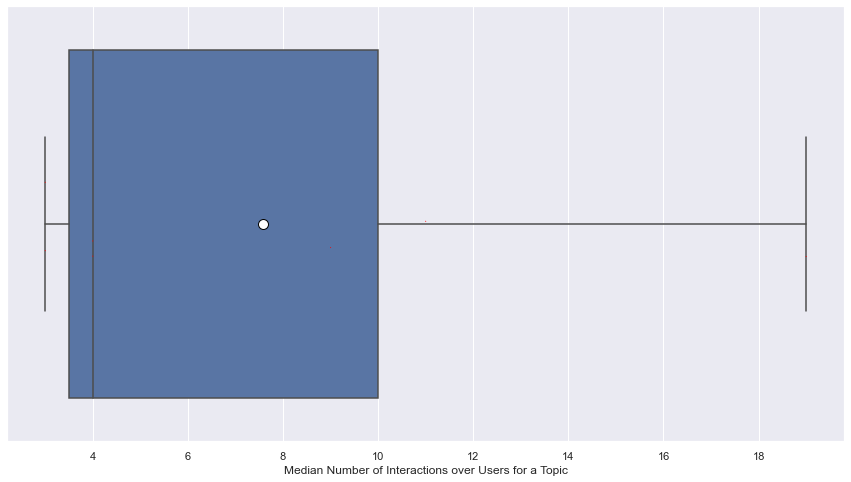

In [56]:
g = sns.boxplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

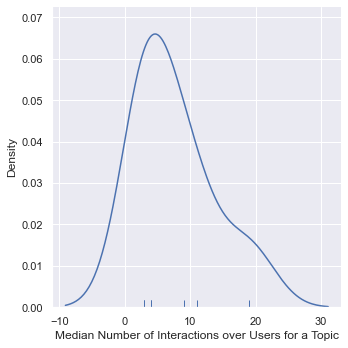

In [57]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

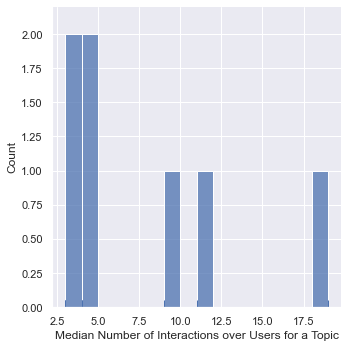

In [58]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

### Avg Number of Unique Learning Activities over Groups for a User

In [59]:
mean_n_unique_learning_activities_over_groups_for_user, median_n_unique_learning_activities_over_groups_for_user = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR)

mean of Mean Number of Unique Learning Resources over Topics for a User: 42.3564245299299
median of Mean Number of Unique Learning Resources over Topics for a User: 13.5
max of Mean Number of Unique Learning Resources over Topics for a User: 2309.0
min of Mean Number of Unique Learning Resources over Topics for a User: 1.0

__________________________________________________

mean of Median Number of Unique Learning Resources over Topics for a User: 32.32847079683785
median of Median Number of Unique Learning Resources over Topics for a User: 10.0
max of Median Number of Unique Learning Resources over Topics for a User: 2309.0
min of Median Number of Unique Learning Resources over Topics for a User: 1.0


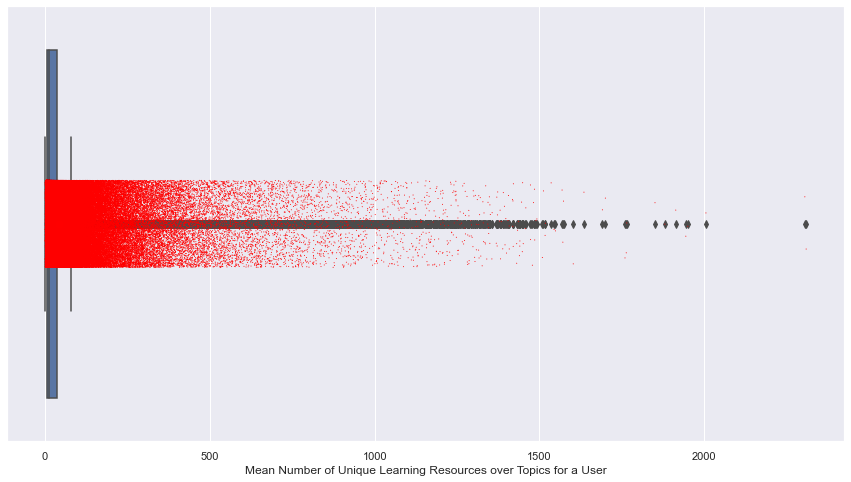

In [60]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

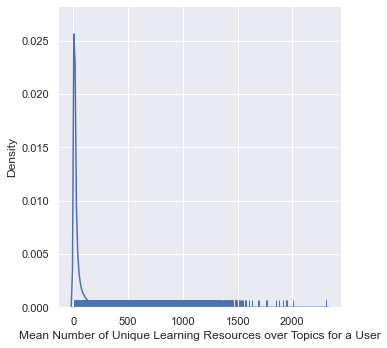

In [61]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

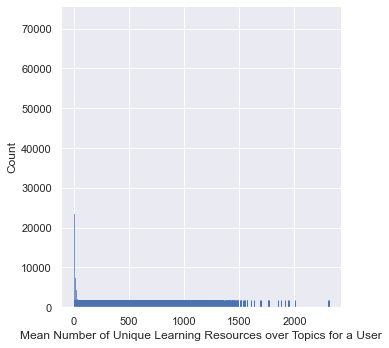

In [62]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

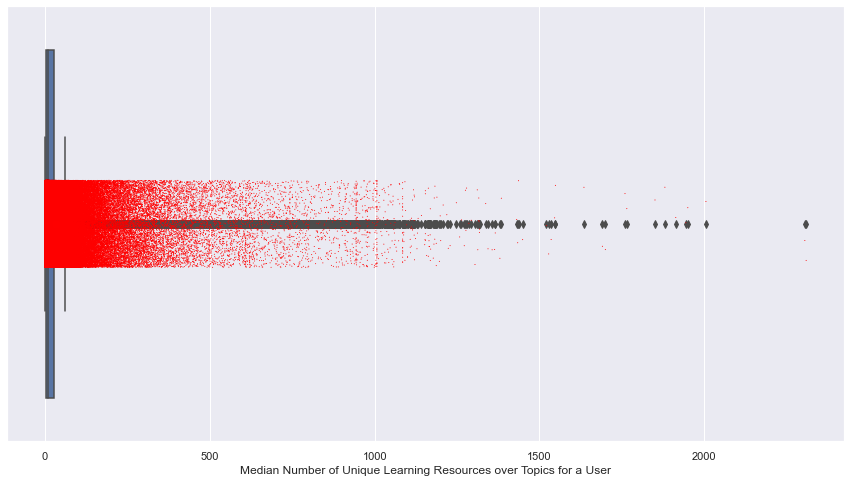

In [63]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

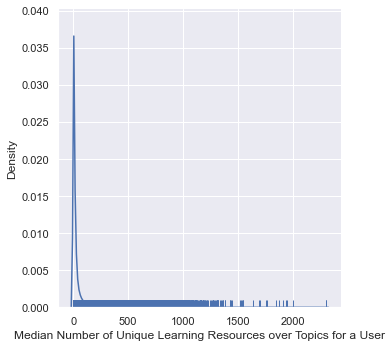

In [64]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

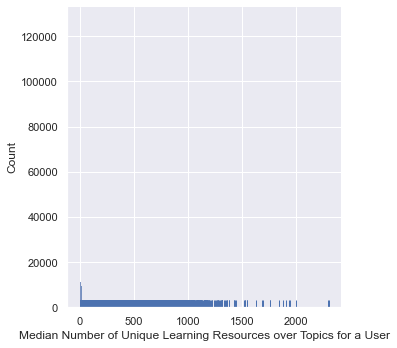

In [65]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

### Avg Number of Unique Learning Activities over Users for a Group

In [66]:
mean_n_unique_learning_activities_over_users_for_group, median_n_unique_learning_activities_over_users_for_group = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR)

mean of Mean Number of Unique Learning Resources over Users for a Topic: 43.35044905249058
median of Mean Number of Unique Learning Resources over Users for a Topic: 37.09720122849413
max of Mean Number of Unique Learning Resources over Users for a Topic: 92.77473110449996
min of Mean Number of Unique Learning Resources over Users for a Topic: 23.642555536445737

__________________________________________________

mean of Median Number of Unique Learning Resources over Users for a Topic: 7.571428571428571
median of Median Number of Unique Learning Resources over Users for a Topic: 4.0
max of Median Number of Unique Learning Resources over Users for a Topic: 19.0
min of Median Number of Unique Learning Resources over Users for a Topic: 3.0


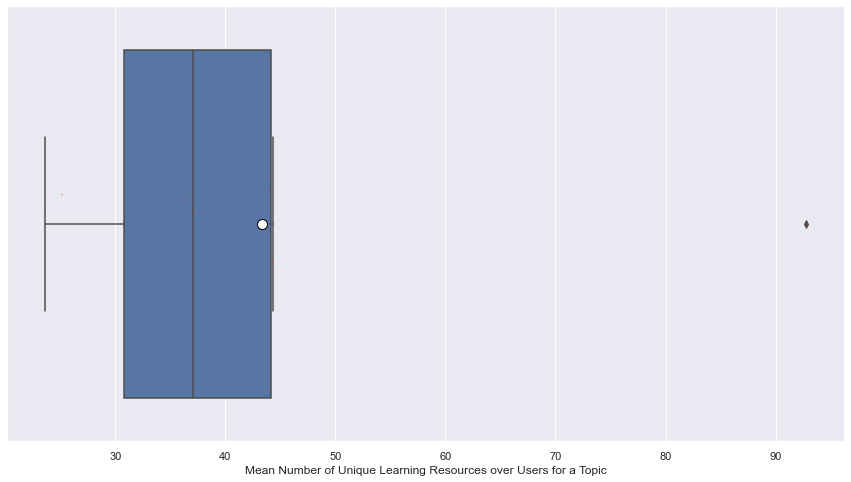

In [67]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

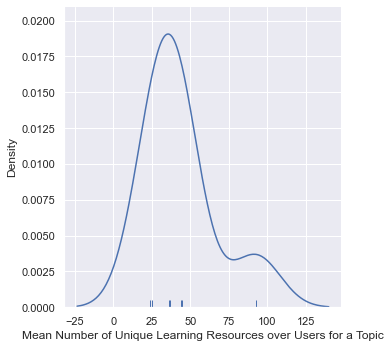

In [68]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

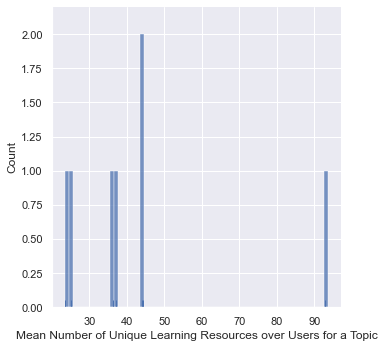

In [69]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

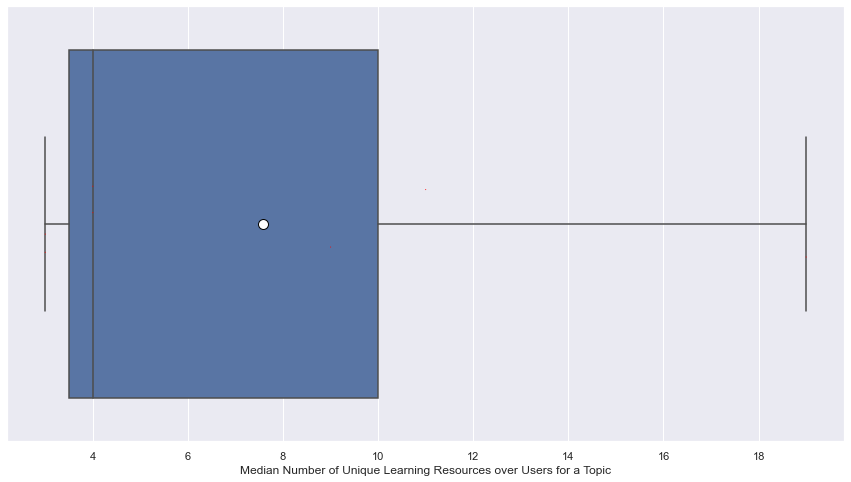

In [70]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

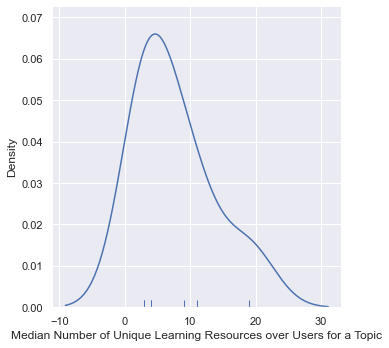

In [71]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

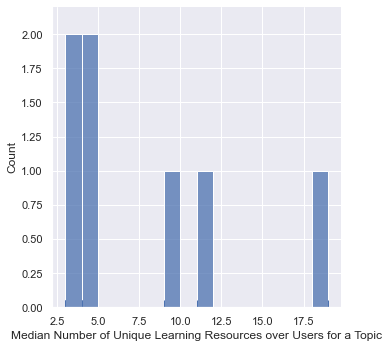

In [72]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

### Sparsity - User_Item_Matrix

#### User-Group

In [73]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[GROUP_FIELD])
print(f"User-{GROUP_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Topic Sparsity: 33.772488815470496 %


#### User-Learning Activity

In [74]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[LEARNING_ACTIVITY_FIELD])
print(f"User-{LEARNING_ACTIVITY_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Learning Resource Sparsity: 98.36820704090006 %


## Unique Sequence Statistics

### Unique User Sequence Statistics per Group

In [ ]:
learning_activity_sequence_stats_per_group = return_col3_sequence_stats_over_col2_per_col1(interactions, 
                                                                                           GROUP_FIELD, 
                                                                                           USER_FIELD, 
                                                                                           LEARNING_ACTIVITY_FIELD,
                                                                                           TIMESTAMP_FIELD,
                                                                                           GROUP_FIELD_NAME_STR,
                                                                                           GROUP_CODE_FIELD_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats_per_group(learning_activity_sequence_stats_per_group,
                              GROUP_CODE_FIELD_NAME_STR, 
                              LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_PER_GROUP_TITLE_NAME_STR)

### Unique User Sequence Statistics

In [ ]:
learning_activity_sequence_stats = return_col2_sequence_stats_over_col1(interactions, 
                                                                        USER_FIELD, 
                                                                        LEARNING_ACTIVITY_FIELD,
                                                                        TIMESTAMP_FIELD,
                                                                        LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats(learning_activity_sequence_stats,
                    LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_TITLE_NAME_STR)

## Sequence Distance

### Sequence Distance between Users per Group

In [ ]:
seq_sim = SeqSim(interactions.head(100000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_per_group_dict = seq_sim.get_user_sequence_distances_per_group(td.levenshtein.distance, sample_pct=80, sample_pct_user=10)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'wb') as f:
    pickle.dump(seq_dist_per_group_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
avg_seq_dist_per_group_df = get_avg_seq_dist_per_group_df(seq_dist_per_group_dict)

In [ ]:
avg_seq_dist_per_group_df

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_distance', size=5, color="red");
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_distance', size=5, color="red");
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', size=5, color="red");
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', size=5, color="red");
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

### Sequence Distance between Users 

In [ ]:
seq_sim = SeqSim(interactions.head(50000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_dict = seq_sim.get_user_sequence_distances(td.levenshtein.distance, sample_pct=20)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, "wb") as f:
    pickle.dump(seq_dist_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
seq_dist_df = get_seq_dist_df(seq_dist_dict)

In [ ]:
seq_dist_df

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='distance', size=5, color="red");
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='normalized_distance', size=5, color="red");
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER+ DATASET_NAME + '_normalized_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');